In [357]:
import argparse

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib.collections import PatchCollection

import random

#python scripts\visualize.py solution-ins-12.txt

def visualize(w, l, n, dims, coords):
    coordsX = [coords[i][0] for i in range(n)]
    coordsY = [coords[i][1] for i in range(n)]
    # print(w, l, n, dims, coordsX, coordsY)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.xlim(0, w)
    plt.ylim(0, l)
    plt.grid(True, color='black')

    myPatches = []
    # myColors = []

    for i in range(n):
        xi_hat = coordsX[i]
        yi_hat = coordsY[i]
        xi = dims[i][0]
        yi = dims[i][1]

        r = patches.Rectangle((xi_hat, yi_hat), xi, yi)
        myPatches.append(r)

    collection = PatchCollection(myPatches, cmap=mpl.cm.hsv, alpha=0.5, edgecolor='black', linewidth=4)
    collection.set_array(np.linspace(0, 254, n, dtype=int))
    #print(np.linspace(0, 200, n, dtype=int))
    collection.set_clim([0, 255])
    ax.add_collection(collection)

    plt.xticks(range(w+1))
    plt.yticks(range(l+1))

    plt.gca().set_aspect('equal', adjustable='box')

    # fig.savefig('figure.png')
    plt.show()

In [310]:
w = 8
n = 4
dims = [[3, 3],
        [3, 5],
        [5, 3],
        [5, 5]]
dimsX = [dims[i][0] for i in range(n)]
dimsY = [dims[i][1] for i in range(n)]

In [311]:
print(dimsX)
print(dimsY)

[3, 3, 5, 5]
[3, 5, 3, 5]


In [312]:
from z3 import *
from itertools import combinations

In [313]:
def at_least_one(B):
    return Or(B)
def at_most_one(B, name=""):
    return And( [Not(And(pair[0], pair[1])) for pair in combinations(B, 2)] )
"""def at_most_one(B, name=""):
    # List which will contain all the formulas for the at_most_one constraint
    formulas_list = []
    
    n = len(B)  # Number of variables
    
    # Defining the new variables (Note: the indeces start from 0)
    s = [Bool(f's_{name}_{i}') for i in range(n-1)]
    
    # LET'S ADD THE FORMULAS, ONE AT A TIME
    
    # First formula
    formulas_list.append( Or(Not(B[0]), s[0]) )
    
    # Second formula
    formulas_list.append( Or(Not(B[n-1]), Not(s[n-2])) )
    
    # Third big formula
    for i in range(1, n-1):
        formula = And( Or(Not(B[i]),s[i]), Or(Not(s[i-1]),s[i]), Or(Not(B[i]),Not(s[i-1])) )
        formulas_list.append(formula)
        
    # Return the conjunction among all the added formulas
    return And(formulas_list)"""
def exactly_one(B, name=''):
    return And(at_least_one(B), at_most_one(B, name=name))

In [314]:
class UnsatError(BaseException):
    pass

In [386]:
def vlsi_sat(w, n, dimsX, dimsY, formulas=[]):
    s = Solver()
    s.add(And(formulas))
    
    l_max = sum(dimsY)
    #print(f'l_max {l_max}')
    #print()
    
    circuits = [[[Bool(f'circuit_{i}_{j}_{k}') for k in range(n)] for j in range(l_max)] for i in range(w)]
    coords = [[[Bool(f'coord_{i}_{j}_{k}') for k in range(n)] for j in range(l_max)] for i in range(w)]
    #coordsY = [[[Bool('coordY_{i}_{j}_{k}') for k in range(n)] for j in range(l_max)] for i in range(w)]
    
    for i in range(w):
        for j in range(l_max):
            s.add(at_most_one(circuits[i][j], name=f'at_most_one_circuit_{i}_{j}'))
            s.add(at_most_one(coords[i][j], name=f'at_most_one_coord_{i}_{j}'))
            
    for k in range(n):
        s.add(exactly_one([coords[i][j][k] for i in range(w) for j in range(l_max)], name=f'exactly_one_{k}'))
            
    for k in range(n):
        for i in range(w):
            for j in range(l_max):
                #print(f'k {k} i {i} j {j}')
                if i+dimsX[k]-1>=w or j+dimsY[k]-1>=l_max:
                    s.add(Not(coords[i][j][k]))
                    continue
                right_positions = [(i+ii,j+jj) for ii in range(dimsX[k]) for jj in range(dimsY[k])]
                #print(right_positions)
                #wrong_positions = sorted(list(set([(i,j) for i in range(w) for j in range(l_max)]) - set(right_positions)))
                #print(wrong_positions)
                ##all_right_pos = And([circuits[ii][jj][k] for (ii,jj) in right_positions])
                #no_wrong_pos = And([Not(circuits[ii][jj][k]) for (ii,jj) in wrong_positions])
                
                #s.add(Implies(coords[i][j][k], And(all_right_pos, no_wrong_pos)))
                formula1 = And([Not(circuits[ii][jj][kk]) for (ii,jj) in right_positions for kk in range(n) if kk!=k])
                formula2 = And([circuits[ii][jj][k] for (ii,jj) in right_positions ])
                #s.add(Implies(coords[i][j][k], formula))
                s.add(coords[i][j][k] == And(formula1,formula2))
                #print()
                
    #s.add(at_least_one(lengths))
                
    if s.check() != sat:
        raise UnsatError()
    
    # return s
    #if s.check() == sat:
    m = s.model()
    #print(m[coords[1][1][1]])
    #return m

    coords_sol = [(i, j, k) for k in range(n) for j in range(l_max) for i in range(w) if m.evaluate(coords[i][j][k])]
    formula = And([ (coords[i][j][k] if m.evaluate(coords[i][j][k]) else Not(coords[i][j][k])) for i in range(w) for j in range(l_max) for k in range(n)])
    return coords_sol, formula
    #else:
    #    return "Unsat" 

In [387]:
%%time
coords_sol, formula = vlsi_sat(w, n, dimsX, dimsY)

Wall time: 3.74 s


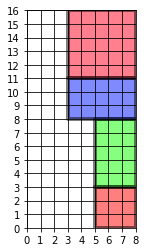

In [388]:
visualize(w, sum(dimsY), n, dims, coords_sol)

In [389]:
coords_sol

[(5, 0, 0), (5, 3, 1), (3, 8, 2), (3, 11, 3)]

In [379]:
def compute_max_l(coords, dimsY, n):
    return max([coords[i][1]+dimsY[i] for i in range(n)])

In [380]:
compute_max_l(coords_sol, dimsY, n)

11

In [390]:
def optimize(w, n, dimsX, dimsY):
    formulas = []
    
    first = True
    
    #best_l = sum(dimsY)+1
    
    while True:
        try:
            coords_sol, formula = vlsi_sat(w, n, dimsX, dimsY, formulas=formulas)
            formulas.append(Not(formula))
            l = compute_max_l(coords_sol, dimsY, n)
            print(l)
            print(coords_sol)
            if first or l < best_l:
                first = False
                best_coords_sol = coords_sol
                best_l = l
                print(f'best_l {best_l}')
        except UnsatError:
            break
            
    if first:
        return 'Unsat'
    
    return best_coords_sol, best_l              

In [391]:
%%time
best_coords_sol, best_l = optimize(w, n, dimsX, dimsY)

16
[(5, 0, 0), (5, 3, 1), (3, 8, 2), (3, 11, 3)]
best_l 16
16
[(2, 0, 0), (5, 3, 1), (3, 8, 2), (3, 11, 3)]
16
[(1, 0, 0), (5, 3, 1), (3, 8, 2), (3, 11, 3)]
16
[(3, 0, 0), (5, 3, 1), (3, 8, 2), (3, 11, 3)]
16
[(1, 5, 0), (5, 3, 1), (3, 8, 2), (3, 11, 3)]


KeyboardInterrupt: 

In [179]:
best_coords_sol

[(0, 0), (1, 0)]

In [180]:
best_l

2

In [408]:
def vlsi_sat(w, n, dimsX, dimsY, formulas=[], l_max=None):
    s = Solver()
    s.add(And(formulas))
    
    if not l_max:
        l_max = sum(dimsY)
    #print(f'l_max {l_max}')
    #print()
    
    circuits = [[[Bool(f'circuit_{i}_{j}_{k}') for k in range(n)] for j in range(l_max)] for i in range(w)]
    coords = [[[Bool(f'coord_{i}_{j}_{k}') for k in range(n)] for j in range(l_max)] for i in range(w)]
    #coordsY = [[[Bool('coordY_{i}_{j}_{k}') for k in range(n)] for j in range(l_max)] for i in range(w)]
    
    lengths = [[Bool(f'length_{k}_{l}') for l in range(l_max)] for k in range(n)]
    
    for i in range(w):
        for j in range(l_max):
            s.add(at_most_one(circuits[i][j], name=f'at_most_one_circuit_{i}_{j}'))
            s.add(at_most_one(coords[i][j], name=f'at_most_one_coord_{i}_{j}'))
            
    for k in range(n):
        s.add(exactly_one([coords[i][j][k] for i in range(w) for j in range(l_max)], name=f'exactly_one_{k}'))
            
    for k in range(n):
        for i in range(w):
            for j in range(l_max):
                #print(f'k {k} i {i} j {j}')
                if i+dimsX[k]-1>=w or j+dimsY[k]-1>=l_max:
                    s.add(Not(coords[i][j][k]))
                    continue
                right_positions = [(i+ii,j+jj) for ii in range(dimsX[k]) for jj in range(dimsY[k])]
                #print(right_positions)
                #wrong_positions = sorted(list(set([(i,j) for i in range(w) for j in range(l_max)]) - set(right_positions)))
                #print(wrong_positions)
                ##all_right_pos = And([circuits[ii][jj][k] for (ii,jj) in right_positions])
                #no_wrong_pos = And([Not(circuits[ii][jj][k]) for (ii,jj) in wrong_positions])
                
                #s.add(Implies(coords[i][j][k], And(all_right_pos, no_wrong_pos)))
                formula1 = And([Not(circuits[ii][jj][kk]) for (ii,jj) in right_positions for kk in range(n) if kk!=k])
                formula2 = And([circuits[ii][jj][k] for (ii,jj) in right_positions ])
                #s.add(Implies(coords[i][j][k], formula))
                
                formula3 = And([Not(lengths[k][l]) for l in range(j+dimsY[k], l_max)])
                formula4 = And([lengths[k][l] for l in range(j+dimsY[k])])
                
                s.add(coords[i][j][k] == And(formula1, formula2))
                s.add(Implies(coords[i][j][k], And(formula3, formula4)))
                
                #print()
                
    #s.add(at_least_one(lengths))
                
    if s.check() != sat:
        raise UnsatError()
    
    # return s
    #if s.check() == sat:
    m = s.model()
    #print(m[coords[1][1][1]])
    #return m

    coords_sol = [(i, j, k) for k in range(n) for j in range(l_max) for i in range(w) if m.evaluate(coords[i][j][k])]
    formula = And([ (coords[i][j][k] if m.evaluate(coords[i][j][k]) else Not(coords[i][j][k])) for i in range(w) for j in range(l_max) for k in range(n)])
    l = max([l for k in range(n) for l in range(l_max) if m.evaluate(lengths[k][l])])+1
    return coords_sol, l, formula
    #else:
    #    return "Unsat" 

In [424]:
def vlsi_sat1(w, n, dimsX, dimsY, formulas=[], l_max=None):
    s = Solver()
    s.add(And(formulas))
    
    if not l_max:
        l_max = sum(dimsY)
    #print(f'l_max {l_max}')
    #print()
    
    circuits = [[[Bool(f'circuit_{i}_{j}_{k}') for k in range(n)] for j in range(l_max)] for i in range(w)]
    coords = [[[Bool(f'coord_{i}_{j}_{k}') for k in range(n)] for j in range(l_max)] for i in range(w)]
    #coordsY = [[[Bool('coordY_{i}_{j}_{k}') for k in range(n)] for j in range(l_max)] for i in range(w)]
    
    for i in range(w):
        for j in range(l_max):
            s.add(at_most_one(circuits[i][j], name=f'at_most_one_circuit_{i}_{j}'))
            s.add(at_most_one(coords[i][j], name=f'at_most_one_coord_{i}_{j}'))
            
    for k in range(n):
        s.add(exactly_one([coords[i][j][k] for i in range(w) for j in range(l_max)], name=f'exactly_one_{k}'))
            
    for k in range(n):
        for i in range(w):
            for j in range(l_max):
                #print(f'k {k} i {i} j {j}')
                if i+dimsX[k]-1>=w or j+dimsY[k]-1>=l_max:
                    s.add(Not(coords[i][j][k]))
                    continue
                right_positions = [(i+ii,j+jj) for ii in range(dimsX[k]) for jj in range(dimsY[k])]
                #print(right_positions)
                #wrong_positions = sorted(list(set([(i,j) for i in range(w) for j in range(l_max)]) - set(right_positions)))
                #print(wrong_positions)
                ##all_right_pos = And([circuits[ii][jj][k] for (ii,jj) in right_positions])
                #no_wrong_pos = And([Not(circuits[ii][jj][k]) for (ii,jj) in wrong_positions])
                
                #s.add(Implies(coords[i][j][k], And(all_right_pos, no_wrong_pos)))
                formula1 = And([Not(circuits[ii][jj][kk]) for (ii,jj) in right_positions for kk in range(n) if kk!=k])
                formula2 = And([circuits[ii][jj][k] for (ii,jj) in right_positions ])
                #s.add(Implies(coords[i][j][k], formula))
                
                s.add(coords[i][j][k] == And(formula1, formula2))                
                #print()
                
    #s.add(at_least_one(lengths))
                
    if s.check() != sat:
        raise UnsatError()
    
    # return s
    #if s.check() == sat:
    m = s.model()
    #print(m[coords[1][1][1]])
    #return m

    coords_sol = [(i, j, k) for k in range(n) for j in range(l_max) for i in range(w) if m.evaluate(coords[i][j][k])]
    formula = And([ (coords[i][j][k] if m.evaluate(coords[i][j][k]) else Not(coords[i][j][k])) for i in range(w) for j in range(l_max) for k in range(n)])

    return coords_sol, formula
    #else:
    #    return "Unsat" 

In [426]:
%%time
coords_sol, formula = vlsi_sat1(w, n, dimsX, dimsY, l_max=8)

Wall time: 1.03 s


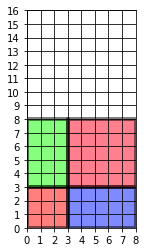

In [427]:
visualize(w, sum(dimsY), n, dims, coords_sol)

In [411]:
l

8

In [412]:
coords_sol

[(5, 0, 0), (5, 3, 1), (0, 5, 2), (0, 0, 3)]

In [400]:
def compute_max_l(coords, dimsY, n):
    return max([coords[i][1]+dimsY[i] for i in range(n)])

In [401]:
compute_max_l(coords_sol, dimsY, n)

16

In [430]:
def optimize(w, n, dimsX, dimsY):
    formulas = []
    
    first = True
    
    l=None
    
    #best_l = sum(dimsY)+1
    
    while True:
        try:
            coords_sol, formula = vlsi_sat1(w, n, dimsX, dimsY, formulas=formulas, l_max=l)
            formulas.append(Not(formula))
            l = compute_max_l(coords_sol, dimsY, n)
            print(l)
            print(coords_sol)
            if first or l < best_l:
                first = False
                best_coords_sol = coords_sol
                best_l = l
                print(f'best_l {best_l}')
            l=l-1
        except UnsatError:
            break
            
    if first:
        return 'Unsat'
    
    return best_coords_sol, best_l              

In [419]:
%%time
best_coords_sol, best_l = optimize(w, n, dimsX, dimsY)

16
[(5, 0, 0), (5, 3, 1), (3, 8, 2), (3, 11, 3)]
best_l 16
15
[(5, 7, 0), (0, 10, 1), (3, 10, 2), (1, 2, 3)]
best_l 15
14
[(2, 3, 0), (5, 1, 1), (3, 6, 2), (3, 9, 3)]
best_l 14
13
[(2, 2, 0), (5, 0, 1), (3, 5, 2), (3, 8, 3)]
best_l 13
12
[(5, 1, 0), (0, 7, 1), (3, 4, 2), (3, 7, 3)]
best_l 12
11
[(5, 0, 0), (0, 6, 1), (3, 3, 2), (3, 6, 3)]
best_l 11
10
[(0, 7, 0), (5, 0, 1), (3, 6, 2), (0, 1, 3)]
best_l 10
9
[(0, 0, 0), (0, 4, 1), (3, 1, 2), (3, 4, 3)]
best_l 9
8
[(0, 0, 0), (0, 3, 1), (3, 0, 2), (3, 3, 3)]
best_l 8
Wall time: 22.6 s


In [431]:
%%time
best_coords_sol, best_l = optimize(w, n, dimsX, dimsY)

16
[(5, 0, 0), (5, 3, 1), (3, 8, 2), (3, 11, 3)]
best_l 16
15
[(2, 4, 0), (5, 2, 1), (3, 7, 2), (3, 10, 3)]
best_l 15
14
[(2, 3, 0), (5, 1, 1), (3, 6, 2), (3, 9, 3)]
best_l 14
13
[(2, 2, 0), (5, 0, 1), (3, 5, 2), (3, 8, 3)]
best_l 13
12
[(5, 1, 0), (0, 7, 1), (3, 4, 2), (3, 7, 3)]
best_l 12
11
[(5, 0, 0), (0, 6, 1), (3, 3, 2), (3, 6, 3)]
best_l 11
10
[(0, 2, 0), (0, 5, 1), (3, 2, 2), (3, 5, 3)]
best_l 10
9
[(0, 1, 0), (0, 4, 1), (3, 1, 2), (3, 4, 3)]
best_l 9
8
[(0, 0, 0), (0, 3, 1), (3, 5, 2), (3, 0, 3)]
best_l 8
Wall time: 21.9 s


In [420]:
best_coords_sol

[(0, 0, 0), (0, 3, 1), (3, 0, 2), (3, 3, 3)]

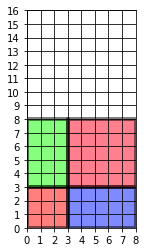

In [421]:
visualize(w, sum(dimsY), n, dims, best_coords_sol)